## **INITIAL STEPS**

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
key = "e69ff83aab45d7956fded3a18728deb77b916560"
df = pdr.get_data_tiingo('TSLA', api_key=key)

<ipython-input-2-4c10af341fd1>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('TSLA', api_key=key)


In [ ]:
df.to_csv('TSLA_stock.csv')

In [ ]:
df=pd.read_csv('TSLA_stock.csv')

In [ ]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2018-11-28 00:00:00+00:00,347.87,348.28,342.21,345.99,4127578,23.191333,23.218667,22.814000,23.066000,61913670,0.0,1.0
1,TSLA,2018-11-29 00:00:00+00:00,341.17,347.50,339.55,347.00,3080724,22.744667,23.166667,22.636667,23.133333,46210860,0.0,1.0
2,TSLA,2018-11-30 00:00:00+00:00,350.48,351.60,338.26,341.83,5628895,23.365333,23.440000,22.550667,22.788667,84433425,0.0,1.0
3,TSLA,2018-12-03 00:00:00+00:00,358.49,366.00,352.00,360.00,8306511,23.899333,24.400000,23.466667,24.000000,124597665,0.0,1.0
4,TSLA,2018-12-04 00:00:00+00:00,359.70,368.68,352.00,356.05,8461945,23.980000,24.578667,23.466667,23.736667,126929175,0.0,1.0


In [ ]:
df1=df.reset_index()['close']
df1=df1.dropna()
df1.head()

0    347.87
1    341.17
2    350.48
3    358.49
4    359.70
Name: close, dtype: float64

## **VISUALIZING THE TESLA STOCK PRICE**

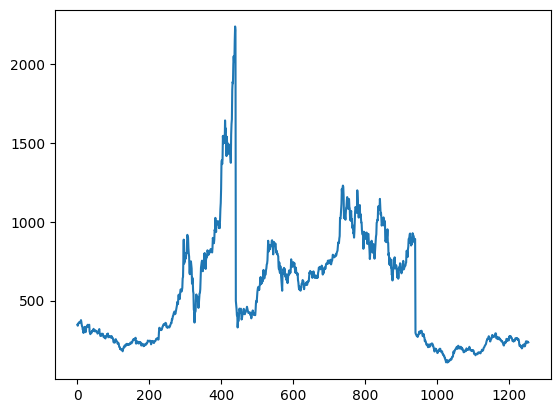

In [ ]:
#Visualizing the graph
import matplotlib.pyplot as plt
plt.plot(df1)

## **MINMAX SCALER**

In [ ]:
#LSTM is sensitive to the range hence we use Minmax scaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(1256, 1)

## **TRAIN-TEST SPLIT** ##

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
train_data.shape

(816, 1)

In [ ]:
test_data.shape

(440, 1)

## **ROLLING WINDOW - CREATING A TIME STEP OF 100**



In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
  dataX, dataY= [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(715, 100)
(715,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
X_train.shape

(715, 100, 1)

In [ ]:
X_test.shape

(339, 100, 1)

## **MAIN FUNCTION CODE**

In [ ]:
def main_code(X_train,y_train,X_test,ytest,model, epochs = 100, batch_size = 64):
  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=epochs,batch_size=batch_size,verbose=1)

  #Prediction time
  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  ##Transformback to original form
  train_predict=scaler.inverse_transform(train_predict) #as we did minmax scaler earlier
  test_predict=scaler.inverse_transform(test_predict)

  #Calculate RMSE performance metrics
  print("Train Mean Squared Error :",math.sqrt(mean_squared_error(y_train,train_predict)))

  ### Test Data RMSE
  print("Test Mean Squared Error: ", math.sqrt(mean_squared_error(ytest,test_predict)))

  # shift train predictions for plotting
  look_back=100
  trainPredictPlot = numpy.empty_like(df1)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  # shift test predictions for plotting
  testPredictPlot = numpy.empty_like(df1)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(df1), label='Actual Stock Price')
  plt.plot(trainPredictPlot, label='Training Data Predictions')
  plt.plot(testPredictPlot, label='Test Data Predictions')
  plt.legend()
  plt.show()

  x_input=test_data[len(test_data)-100:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  lst_output=[]
  n_steps=100
  i=0
  while(i<30):

      if(len(temp_input)>100):
          #print(temp_input)
          x_input=np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          #print(temp_input)
          lst_output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          print(len(temp_input))
          lst_output.extend(yhat.tolist())
          i=i+1

  day_new=np.arange(1,101)
  day_pred=np.arange(101,131)
  plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
  plt.plot(day_pred,scaler.inverse_transform(lst_output))
  plt.show()

  df3=df1.tolist()
  df3.extend(lst_output)
  plt.plot(df3[1100:])
  plt.show()

  df3=scaler.inverse_transform(df3).tolist()
  plt.plot(df3)
  plt.show()

## **MODEL 1 - RECURRENT NEURAL NETWORKS (RNN)**

In [ ]:
# Define the model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(100, 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 7s 87ms/step - loss: 0.0573 - val_loss: 0.0090
Epoch 2/100
12/12 [==============================] - 1s 65ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 3/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0077 - val_loss: 0.0033
Epoch 4/100
12/12 [==============================] - 1s 70ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 5/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 6/100
12/12 [==============================] - 1s 69ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 7/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 8/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 9/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 10/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0026 - val_loss: 9.3479

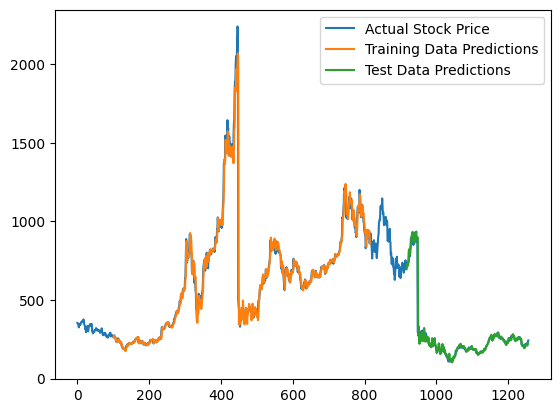

[0.06173815]
101
1 day input [0.06952808 0.07011945 0.07212353 0.08059512 0.08184357 0.07905569
 0.07806538 0.07580316 0.07588764 0.07692019 0.07969399 0.08132729
 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218 0.07554502
 0.07377091 0.07333443 0.06927933 0.07431535 0.07478    0.07179499
 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859 0.06293385
 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749 0.0521531
 0.05040246 0.05781334 0.05870978 0.06043226 0.05723136 0.06124422
 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739 0.06964541
 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346 0.07659634
 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839 0.06927463
 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038 0.06670265
 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155 0.07113792
 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921 0.0688757
 0.06316382 0.05257081 0.04875977 0.04880201 0.05088588 0.04896158
 0.04583578 0.04655856 0.04189332 0

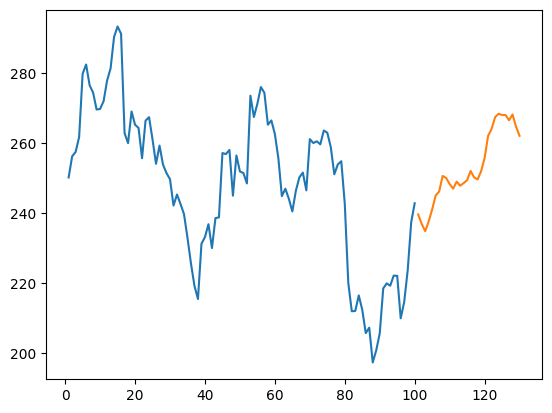

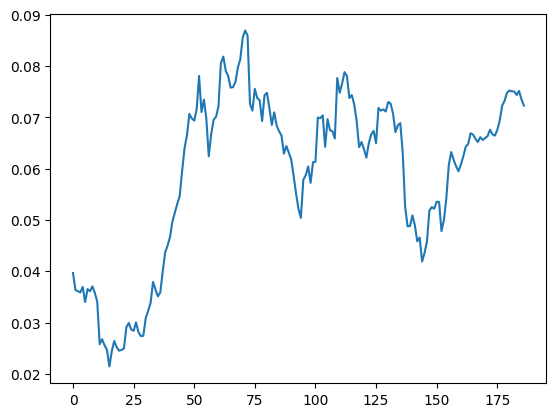

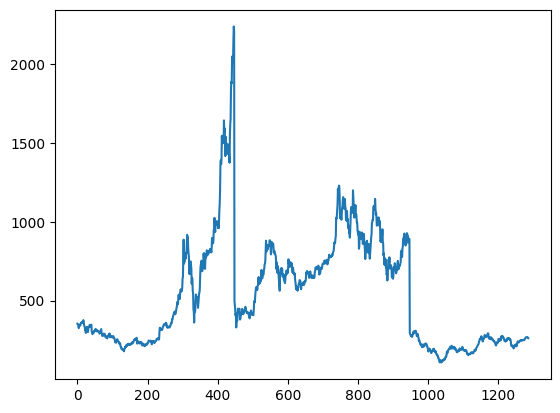

In [ ]:
#Calling the main function
main_code(X_train,y_train,X_test,ytest,model)

## **MODEL 2 - STACKED RECURRENT NEURAL NETWORK (RNN)**

In [ ]:
# Define the model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(100, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100, 50)           2600      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 50)           5050      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12751 (49.81 KB)
Trainable params: 12751 (49.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 8s 465ms/step - loss: 0.0719 - val_loss: 0.0298
Epoch 2/100
12/12 [==============================] - 3s 268ms/step - loss: 0.0157 - val_loss: 0.0095
Epoch 3/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 4/100
12/12 [==============================] - 3s 263ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 5/100
12/12 [==============================] - 5s 434ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/100
12/12 [==============================] - 3s 238ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 7/100
12/12 [==============================] - 3s 244ms/step - loss: 0.0027 - val_loss: 9.2797e-04
Epoch 8/100
12/12 [==============================] - 3s 235ms/step - loss: 0.0025 - val_loss: 9.7169e-04
Epoch 9/100
12/12 [==============================] - 5s 455ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/100
12/12 [==============================] - 3s 269ms/step - loss: 0.0026 

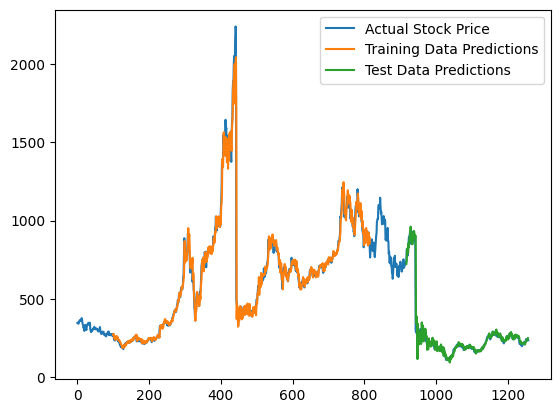

[0.06496967]
101
1 day input [0.07806538 0.07580316 0.07588764 0.07692019 0.07969399 0.08132729
 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218 0.07554502
 0.07377091 0.07333443 0.06927933 0.07431535 0.07478    0.07179499
 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859 0.06293385
 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749 0.0521531
 0.05040246 0.05781334 0.05870978 0.06043226 0.05723136 0.06124422
 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739 0.06964541
 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346 0.07659634
 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839 0.06927463
 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038 0.06670265
 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155 0.07113792
 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921 0.0688757
 0.06316382 0.05257081 0.04875977 0.04880201 0.05088588 0.04896158
 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884 0.05181987
 0.05250041 0.05217657 0.05354235 0

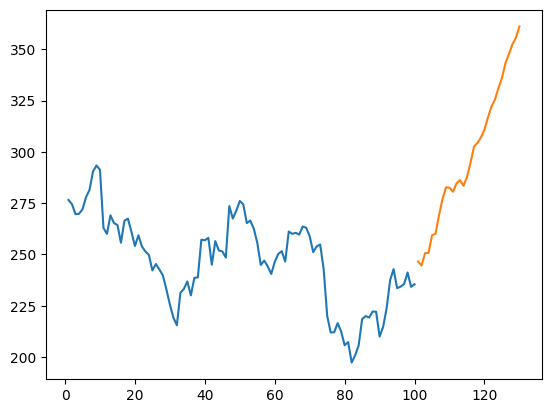

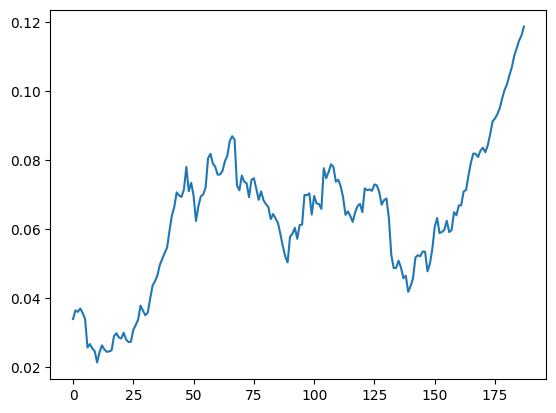

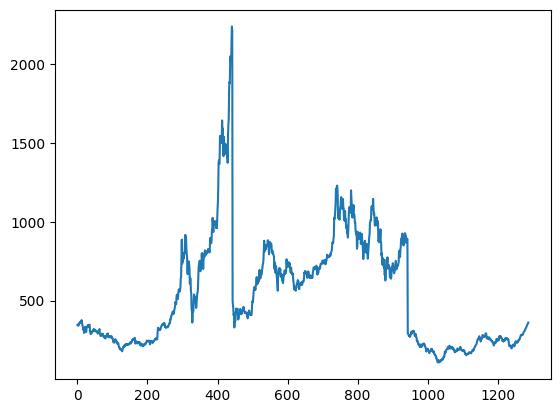

In [ ]:
#Calling the main function
main_code(X_train,y_train,X_test,ytest,model)

## **MODEL 3 - STACKED LONG SHORT TERM MEMORY - RECURRENT NEURAL NETWORK (LSTM RNN)**

In [ ]:
# Define the model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error',optimizer='adam')

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 7s 112ms/step - loss: 0.0305 - val_loss: 0.0049
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0087 - val_loss: 0.0048
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 9/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 10/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0055 - val_loss: 0.002

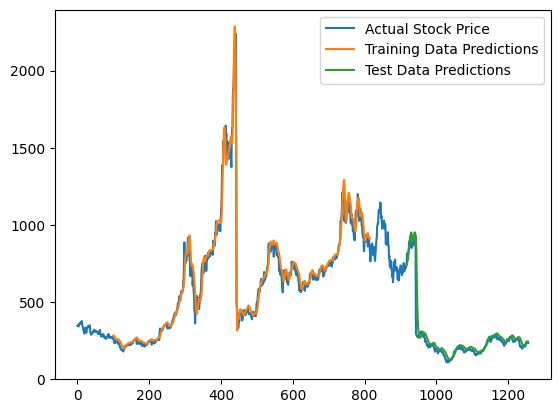

[0.06600522]
101
1 day input [0.07905569 0.07806538 0.07580316 0.07588764 0.07692019 0.07969399
 0.08132729 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218
 0.07554502 0.07377091 0.07333443 0.06927933 0.07431535 0.07478
 0.07179499 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859
 0.06293385 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749
 0.0521531  0.05040246 0.05781334 0.05870978 0.06043226 0.05723136
 0.06124422 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739
 0.06964541 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346
 0.07659634 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839
 0.06927463 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038
 0.06670265 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155
 0.07113792 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921
 0.0688757  0.06316382 0.05257081 0.04875977 0.04880201 0.05088588
 0.04896158 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884
 0.05181987 0.05250041 0.05217657 0.

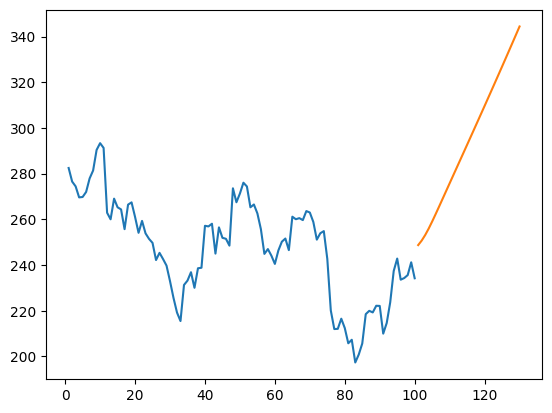

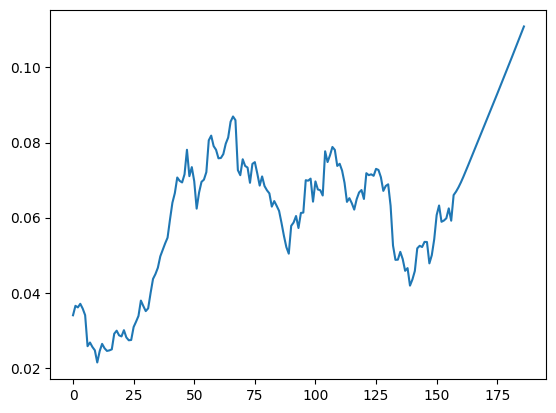

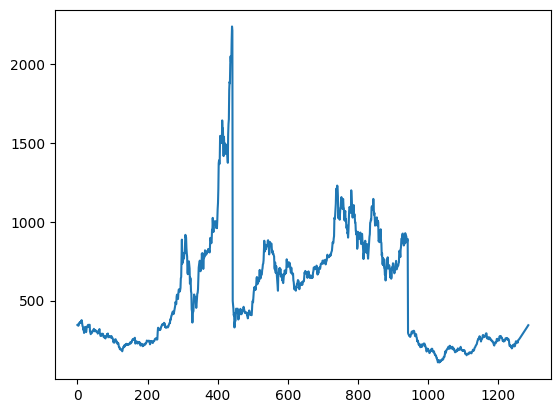

In [ ]:
#Calling the main function
main_code(X_train,y_train,X_test,ytest,model)

## **MODEL 4 - GATED RECURRENT UNIT (GRU)**

In [ ]:
from keras.layers import GRU

# Define the model with GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(100, 1)))
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 100, 50)           7950      
                                                                 
 gru_7 (GRU)                 (None, 100, 50)           15300     
                                                                 
 gru_8 (GRU)                 (None, 50)                15300     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38601 (150.79 KB)
Trainable params: 38601 (150.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 6s 104ms/step - loss: 0.0342 - val_loss: 0.0147
Epoch 2/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0084 - val_loss: 0.0041
Epoch 3/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 4/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 5/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0033 - val_loss: 7.9021e-04
Epoch 6/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0030 - val_loss: 7.9514e-04
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 8.3174e-04
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 6.8683e-04
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 9.5309e-04
Epoch 10/100
12/12 [==============================] - 0s 27ms/step - loss: 0.00

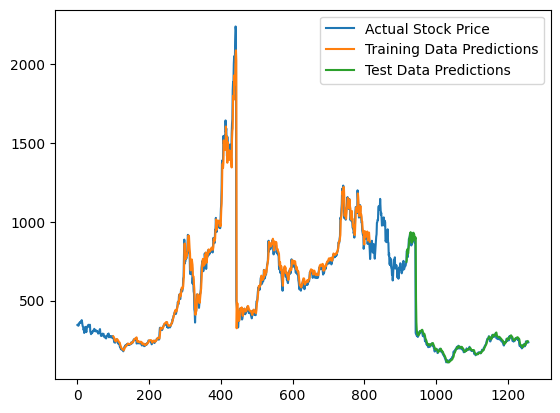

[0.06200334]
101
1 day input [0.07806538 0.07580316 0.07588764 0.07692019 0.07969399 0.08132729
 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218 0.07554502
 0.07377091 0.07333443 0.06927933 0.07431535 0.07478    0.07179499
 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859 0.06293385
 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749 0.0521531
 0.05040246 0.05781334 0.05870978 0.06043226 0.05723136 0.06124422
 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739 0.06964541
 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346 0.07659634
 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839 0.06927463
 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038 0.06670265
 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155 0.07113792
 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921 0.0688757
 0.06316382 0.05257081 0.04875977 0.04880201 0.05088588 0.04896158
 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884 0.05181987
 0.05250041 0.05217657 0.05354235 0

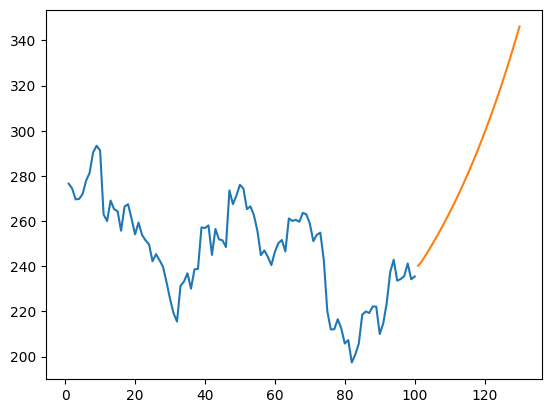

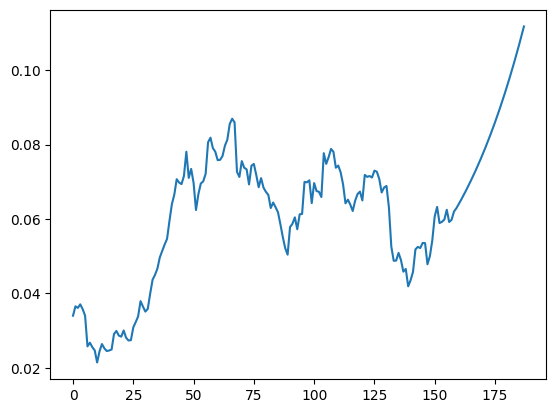

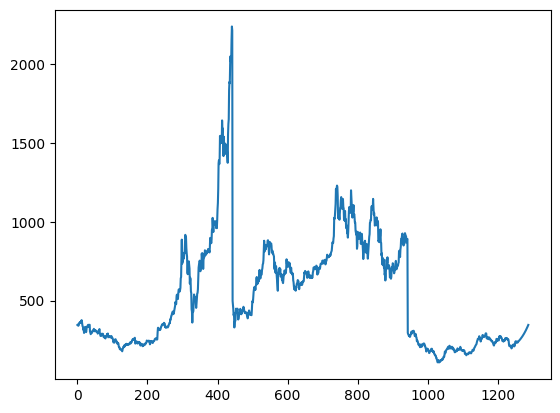

In [ ]:
main_code(X_train,y_train,X_test,ytest,model)

## **HYPER PARAMETER TUNING FOR EACH MODEL**

In [ ]:
pip install scikeras

### **FOR RNN**

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from scikeras.wrappers import KerasRegressor

def build_rnn_model(activation='relu', units = 50, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(100, 1)))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
param_dist = {
    'units': [20, 50, 100],  # Different numbers of units in RNN layer
    'optimizer': ['adam', 'rmsprop'],  # Different optimizers
    'batch_size': [16, 32, 64],  # Different batch sizes
    'epochs': [ 50, 100, 150]  # Different numbers of epochs
}
from sklearn.model_selection import RandomizedSearchCV

model = KerasRegressor(model=build_rnn_model,verbose =0,activation='relu', units = 50)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
random_search_result = random_search.fit(X_train, y_train)  # Use your training data here
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Best: 0.947625 using {'units': 50, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 64}


In [ ]:
cv_results = random_search_result.cv_results_

# Iterate over all results and print them
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("%f with: %r" % (mean_score, params))

-0.379469 with: {'units': 50, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32}
0.913860 with: {'units': 50, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 64}
-0.016199 with: {'units': 20, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 64}
0.943310 with: {'units': 20, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 16}
0.923581 with: {'units': 100, 'optimizer': 'adam', 'epochs': 100, 'batch_size': 64}
-0.377549 with: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 50, 'batch_size': 16}
0.916869 with: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 16}
0.947625 with: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 64}
0.938040 with: {'units': 20, 'optimizer': 'rmsprop', 'epochs': 50, 'batch_size': 16}
0.942290 with: {'units': 100, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 32}


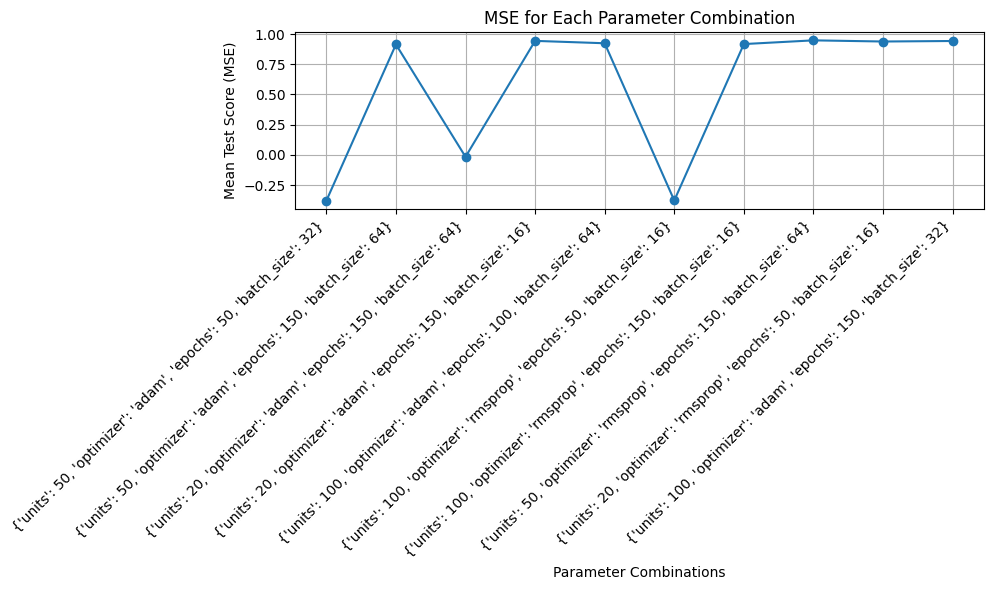

In [ ]:
mean_test_scores = random_search_result.cv_results_['mean_test_score']

# Extract parameter settings for each combination
param_combinations = [str(params) for params in random_search_result.cv_results_['params']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_combinations, mean_test_scores, marker='o')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Test Score (MSE)')
plt.title('MSE for Each Parameter Combination')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 50)                2600      
                                                                 
 dense_32 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
12/12 [==============================] - 5s 93ms/step - loss: 0.0224 - val_loss: 0.0031
Epoch 2/150
12/12 [==============================] - 1s 58ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 3/150
12/12 [==============================] - 1s 66ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 4/150
12/12 [==============================] - 1s 62ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 5/150
12/

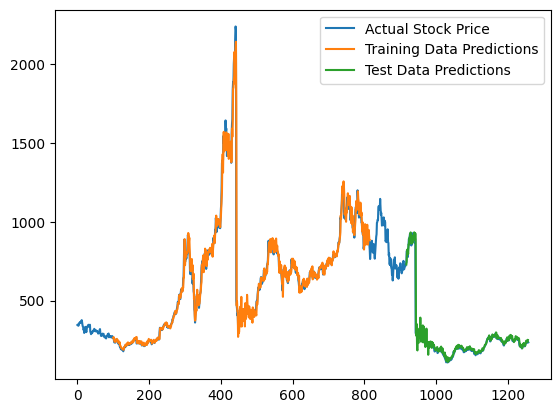

[0.06327355]
101
1 day input [0.07806538 0.07580316 0.07588764 0.07692019 0.07969399 0.08132729
 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218 0.07554502
 0.07377091 0.07333443 0.06927933 0.07431535 0.07478    0.07179499
 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859 0.06293385
 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749 0.0521531
 0.05040246 0.05781334 0.05870978 0.06043226 0.05723136 0.06124422
 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739 0.06964541
 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346 0.07659634
 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839 0.06927463
 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038 0.06670265
 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155 0.07113792
 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921 0.0688757
 0.06316382 0.05257081 0.04875977 0.04880201 0.05088588 0.04896158
 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884 0.05181987
 0.05250041 0.05217657 0.05354235 0

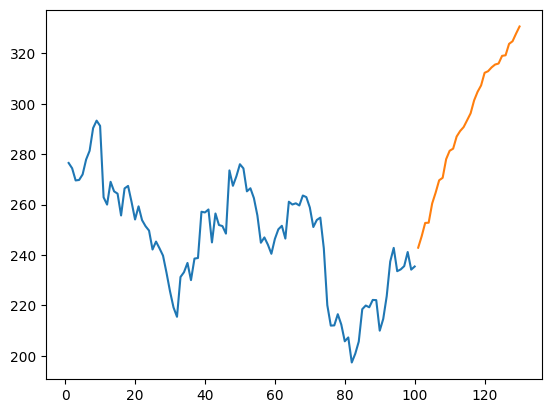

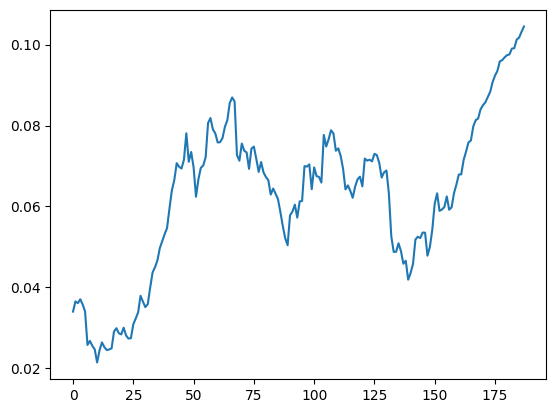

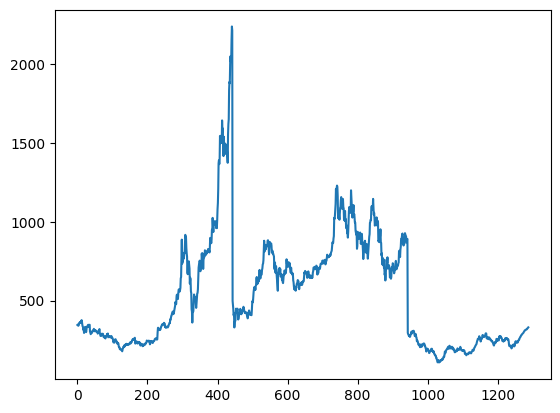

In [ ]:
# Define the model
model = Sequential()
model.add(SimpleRNN(random_search_result.best_params_['units'], input_shape=(100, 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=random_search_result.best_params_['optimizer'])

# Model summary
model.summary()

#Calling the main function
main_code(X_train,y_train,X_test,ytest,model,epochs = random_search_result.best_params_['epochs'],batch_size = random_search_result.best_params_['batch_size'])

### **FOR GRU**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import RandomizedSearchCV

# Function to create the GRU model
def create_gru_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, return_sequences=True, input_shape=(100, 1)))
    model.add(GRU(units, return_sequences=True))
    model.add(GRU(units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap Keras model in a scikit-learn estimator
model = KerasRegressor(build_fn=create_gru_model, verbose=0, units = 50)

# Define the hyperparameters grid to be searched
param_dist = {
    'units': [30, 50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50,100,150]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)

# Fit RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train)

# Print the best score and best hyperparameters
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best: 0.953608 using {'units': 50, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 16}


In [ ]:
cv_results = random_search_result.cv_results_

# Iterate over all results and print them
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("%f with: %r" % (mean_score, params))

0.920003 with: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 32}
0.920461 with: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 16}
0.915171 with: {'units': 50, 'optimizer': 'adam', 'epochs': 100, 'batch_size': 32}
0.936825 with: {'units': 30, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 32}
0.928264 with: {'units': 100, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 32}
0.953608 with: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 16}
0.949543 with: {'units': 30, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 64}
0.928691 with: {'units': 30, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 16}
0.951039 with: {'units': 50, 'optimizer': 'adam', 'epochs': 100, 'batch_size': 64}
0.911312 with: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 64}


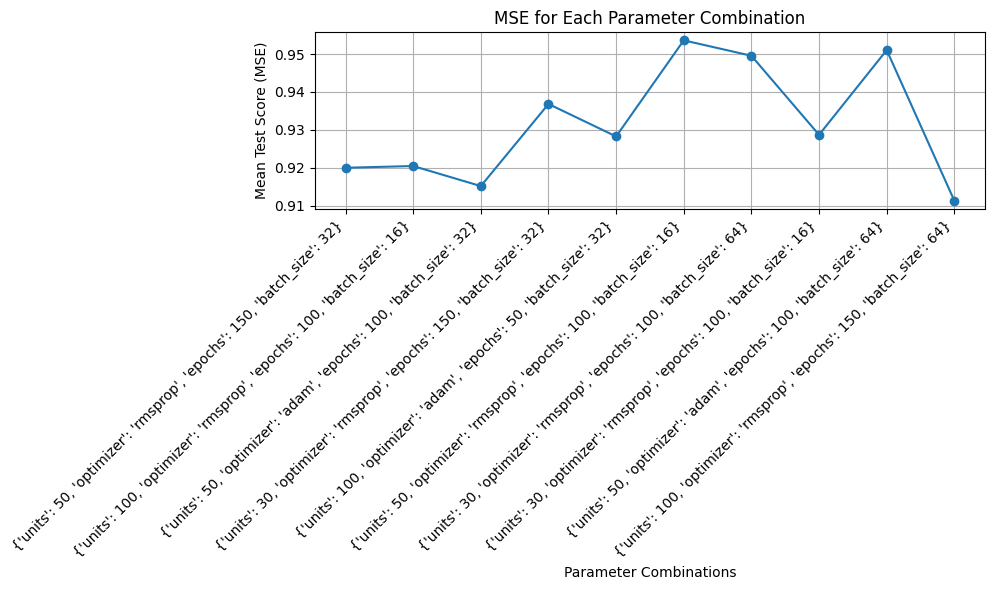

In [ ]:
mean_test_scores = random_search_result.cv_results_['mean_test_score']

# Extract parameter settings for each combination
param_combinations = [str(params) for params in random_search_result.cv_results_['params']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_combinations, mean_test_scores, marker='o')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Test Score (MSE)')
plt.title('MSE for Each Parameter Combination')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_246 (GRU)               (None, 100, 50)           7950      
                                                                 
 gru_247 (GRU)               (None, 100, 50)           15300     
                                                                 
 gru_248 (GRU)               (None, 50)                15300     
                                                                 
 dense_86 (Dense)            (None, 1)                 51        
                                                                 
Total params: 38601 (150.79 KB)
Trainable params: 38601 (150.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
45/45 [==============================] - 6s 36ms/step - loss: 0.0098 - val_loss: 0.0013
Epoch 2/100
45/45 [============================

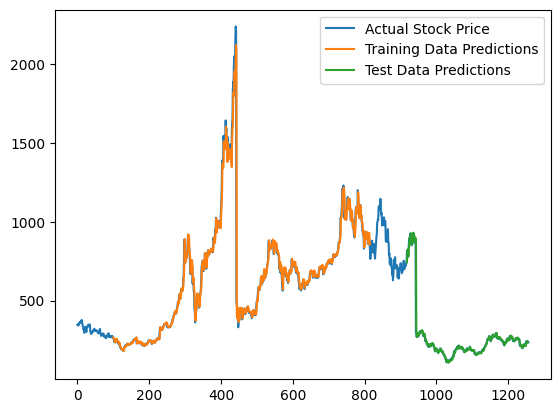

[0.05990028]
101
1 day input [0.07905569 0.07806538 0.07580316 0.07588764 0.07692019 0.07969399
 0.08132729 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218
 0.07554502 0.07377091 0.07333443 0.06927933 0.07431535 0.07478
 0.07179499 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859
 0.06293385 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749
 0.0521531  0.05040246 0.05781334 0.05870978 0.06043226 0.05723136
 0.06124422 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739
 0.06964541 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346
 0.07659634 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839
 0.06927463 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038
 0.06670265 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155
 0.07113792 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921
 0.0688757  0.06316382 0.05257081 0.04875977 0.04880201 0.05088588
 0.04896158 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884
 0.05181987 0.05250041 0.05217657 0.

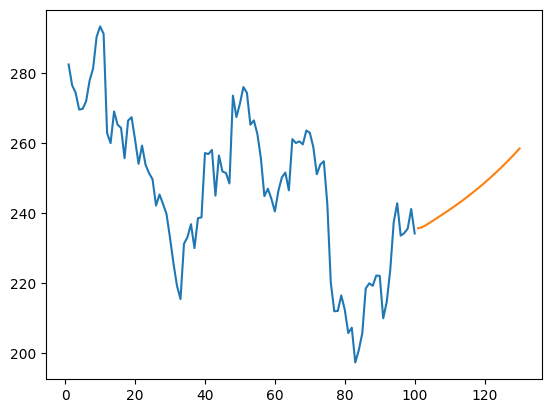

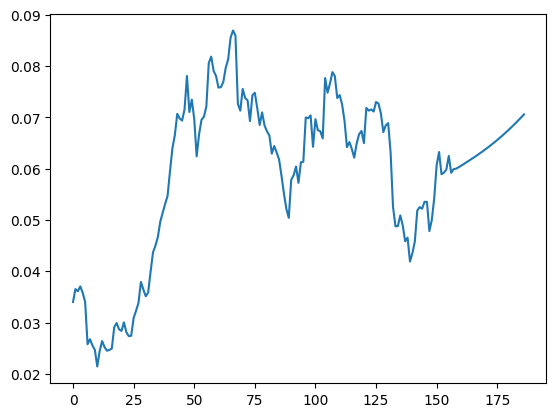

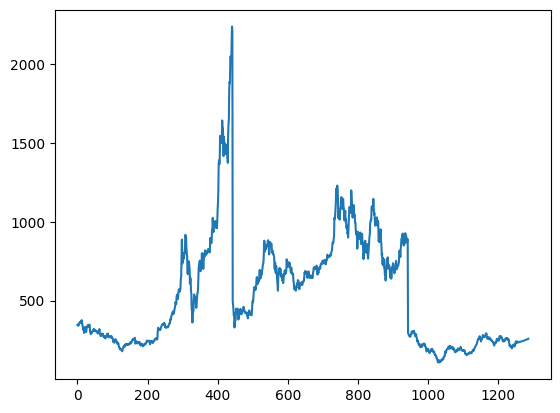

In [ ]:
from keras.layers import GRU

# Define the model with GRU
model = Sequential()
model.add(GRU(random_search_result.best_params_['units'], return_sequences=True, input_shape=(100, 1)))
model.add(GRU(random_search_result.best_params_['units'], return_sequences=True))
model.add(GRU(random_search_result.best_params_['units']))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=random_search_result.best_params_['optimizer'])

# Model summary
model.summary()

main_code(X_train,y_train,X_test,ytest,model, epochs = random_search_result.best_params_['epochs'], batch_size = random_search_result.best_params_['batch_size'])

### **FOR LSTM**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

# Function to create the model (needed for KerasRegressor)
def create_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(100, 1)))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap Keras model as a scikit-learn estimator
model = KerasRegressor(model=create_model, verbose=0, units = 50)

# Define the hyperparameters grid to be searched
param_dist = {
    'units': [30, 50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)

# Fit RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train)

# Print the best score and best hyperparameters
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Best: 0.946569 using {'units': 100, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 16}


In [ ]:
cv_results = random_search_result.cv_results_

# Iterate over all results and print them
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("%f with: %r" % (mean_score, params))

0.912600 with: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 16}
0.917119 with: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 16}
0.927533 with: {'units': 50, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 16}
0.924590 with: {'units': 30, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 16}
0.937721 with: {'units': 50, 'optimizer': 'adam', 'epochs': 100, 'batch_size': 16}
0.946569 with: {'units': 100, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 16}
0.903346 with: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 64}
0.897993 with: {'units': 50, 'optimizer': 'adam', 'epochs': 150, 'batch_size': 32}
0.910736 with: {'units': 30, 'optimizer': 'rmsprop', 'epochs': 150, 'batch_size': 16}
0.839865 with: {'units': 30, 'optimizer': 'rmsprop', 'epochs': 100, 'batch_size': 64}


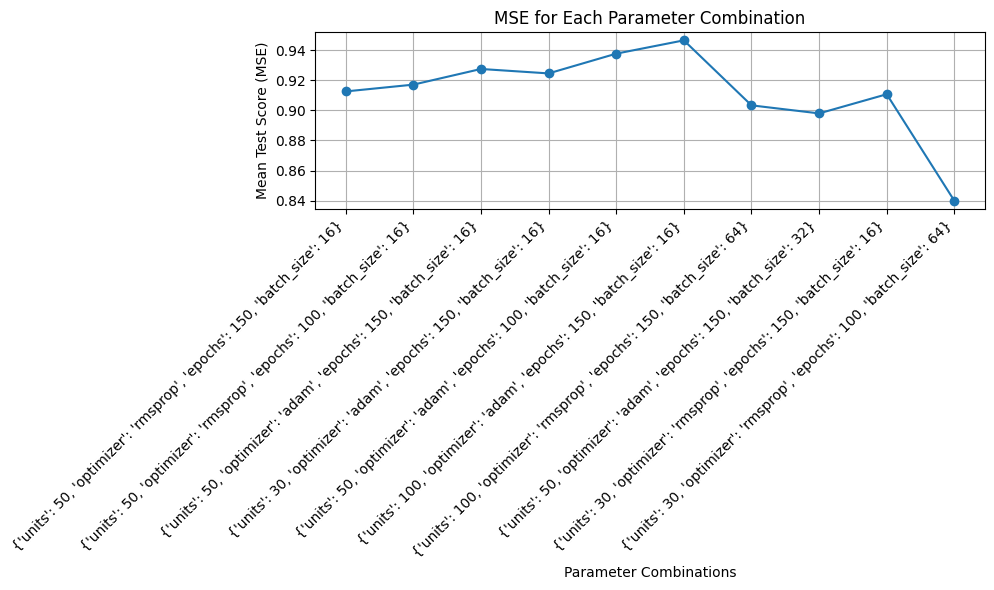

In [ ]:
mean_test_scores = random_search_result.cv_results_['mean_test_score']

# Extract parameter settings for each combination
param_combinations = [str(params) for params in random_search_result.cv_results_['params']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_combinations, mean_test_scores, marker='o')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Test Score (MSE)')
plt.title('MSE for Each Parameter Combination')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 100, 100)          40800     
                                                                 
 lstm_94 (LSTM)              (None, 100, 100)          80400     
                                                                 
 lstm_95 (LSTM)              (None, 100)               80400     
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 201701 (787.89 KB)
Trainable params: 201701 (787.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
45/45 [==============================] - 7s 49ms/step - loss: 0.0158 - val_loss: 0.0058
Epoch 2/150
45/45 [==========================

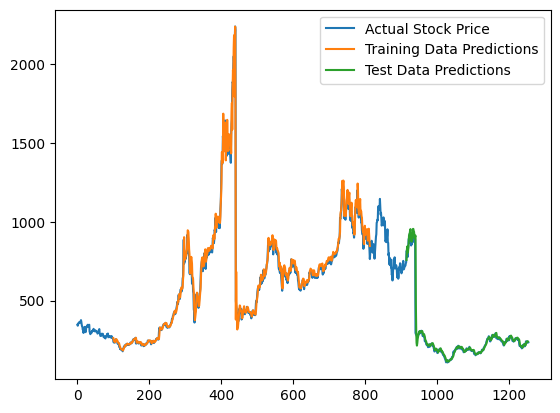

[0.06085452]
101
1 day input [0.07806538 0.07580316 0.07588764 0.07692019 0.07969399 0.08132729
 0.08555136 0.0869406  0.08596438 0.07265388 0.07130218 0.07554502
 0.07377091 0.07333443 0.06927933 0.07431535 0.07478    0.07179499
 0.06852838 0.07097365 0.06841105 0.06727994 0.06645859 0.06293385
 0.06441227 0.06314974 0.06179335 0.05860184 0.05514749 0.0521531
 0.05040246 0.05781334 0.05870978 0.06043226 0.05723136 0.06124422
 0.06135217 0.06996926 0.06983784 0.07039166 0.06425739 0.06964541
 0.06750053 0.06729871 0.06589538 0.07766644 0.07480346 0.07659634
 0.07882102 0.07804661 0.07377091 0.07434351 0.07250839 0.06927463
 0.06419637 0.06518668 0.06383967 0.06214066 0.06490038 0.06670265
 0.06735034 0.06497078 0.07183723 0.07131626 0.07154155 0.07113792
 0.07299181 0.07269613 0.07076244 0.06712506 0.06843921 0.0688757
 0.06316382 0.05257081 0.04875977 0.04880201 0.05088588 0.04896158
 0.04583578 0.04655856 0.04189332 0.04352662 0.04578884 0.05181987
 0.05250041 0.05217657 0.05354235 0

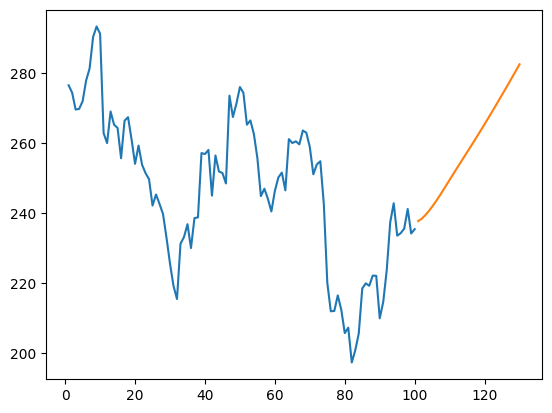

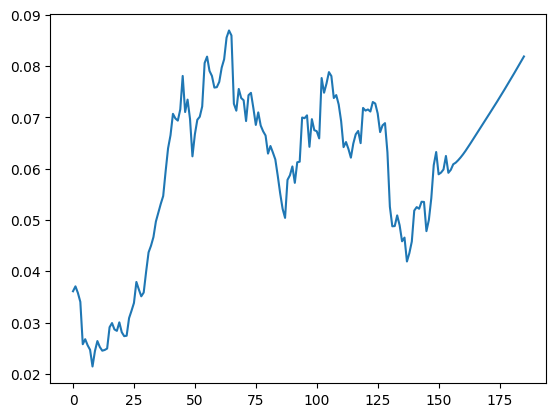

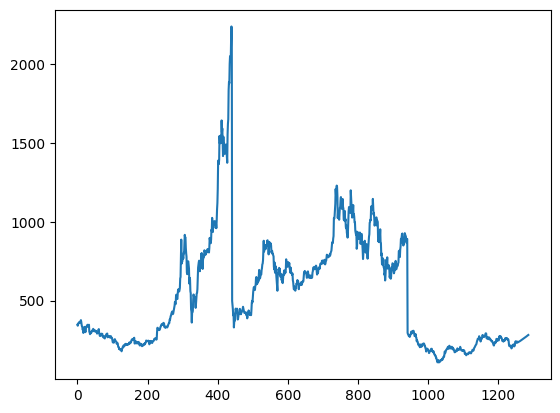

In [ ]:
# Define the model
model=Sequential()
model.add(LSTM(random_search_result.best_params_['units'],return_sequences=True,input_shape=(100,1)))
model.add(LSTM(random_search_result.best_params_['units'],return_sequences=True))
model.add(LSTM(random_search_result.best_params_['units']))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error',optimizer=random_search_result.best_params_['optimizer'])

# Model summary
model.summary()

#Calling the main function
main_code(X_train,y_train,X_test,ytest,model, epochs = random_search_result.best_params_['epochs'], batch_size = random_search_result.best_params_['batch_size'])